In [2]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset

In [5]:
# data_flag = 'bloodmnist'
# data_flag = 'breastmnist'
data_flag = 'pneumoniamnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/4170669 [00:00<?, ?it/s]

Using downloaded and verified file: /Users/emtzhou/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/emtzhou/.medmnist/pneumoniamnist.npz


In [7]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /Users/emtzhou/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 524
    Root location: /Users/emtzhou/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumoni

In [8]:
# visualization

train_dataset.montage(length=1)

/opt/anaconda3/lib/python3.9/site-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


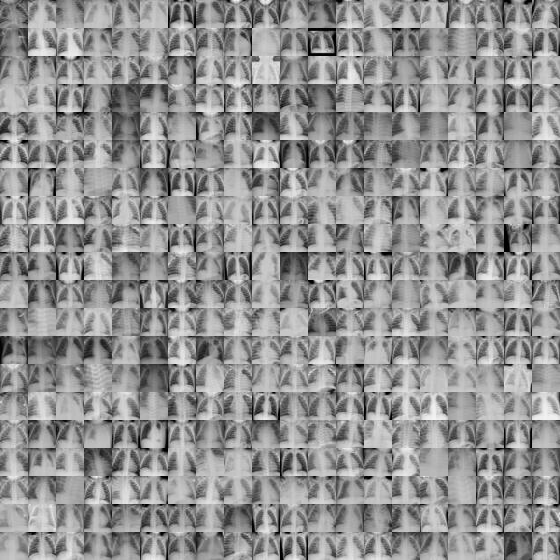

In [9]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [10]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()


In [11]:
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    if split == 'train':
        data_loader = train_loader
    elif split == 'val':
        data_loader = val_loader
    else:
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

## Next, we can start to train and evaluate!

In [12]:
# train
model = Net(in_channels=n_channels, num_classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    
    loss_all = 0
    num_correct, num_all, auc_train = 0, 0, 0
    
    for inputs, targets in tqdm(train_loader, ncols=50):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        loss_all += loss.item() * targets.shape[0]
        pred_class = torch.argmax(outputs, dim=1)
        num_correct += torch.sum(pred_class == targets)
        num_all += targets.shape[0]
    print('Epoch %d, train accuracy %.4f, loss %.4f' % (epoch, num_correct/num_all, loss_all/num_all))
    
    # validation
    model.eval()
    
    print('==> Evaluating ...')
    test('train')
    test('val')

test('test')   

100%|█████████████| 37/37 [00:05<00:00,  7.33it/s]


Epoch 0, train accuracy 0.6691, loss 0.6174
==> Evaluating ...
train  auc: 0.510  acc:0.742
val  auc: 0.752  acc:0.742


100%|█████████████| 37/37 [00:04<00:00,  7.75it/s]


Epoch 1, train accuracy 0.9184, loss 0.3091
==> Evaluating ...
train  auc: 0.484  acc:0.623
val  auc: 0.974  acc:0.933


100%|█████████████| 37/37 [00:05<00:00,  7.40it/s]


Epoch 2, train accuracy 0.9380, loss 0.1676
==> Evaluating ...
train  auc: 0.515  acc:0.626
val  auc: 0.981  acc:0.945


100%|█████████████| 37/37 [00:04<00:00,  7.73it/s]


Epoch 3, train accuracy 0.9465, loss 0.1364
==> Evaluating ...
train  auc: 0.502  acc:0.609
val  auc: 0.987  acc:0.943


100%|█████████████| 37/37 [00:05<00:00,  7.28it/s]


Epoch 4, train accuracy 0.9573, loss 0.1174
==> Evaluating ...
train  auc: 0.496  acc:0.630
val  auc: 0.991  acc:0.952


100%|█████████████| 37/37 [00:05<00:00,  6.74it/s]


Epoch 5, train accuracy 0.9650, loss 0.1027
==> Evaluating ...
train  auc: 0.514  acc:0.640
val  auc: 0.993  acc:0.948


100%|█████████████| 37/37 [00:04<00:00,  7.82it/s]


Epoch 6, train accuracy 0.9652, loss 0.0941
==> Evaluating ...
train  auc: 0.507  acc:0.624
val  auc: 0.993  acc:0.969


100%|█████████████| 37/37 [00:04<00:00,  7.87it/s]


Epoch 7, train accuracy 0.9705, loss 0.0856
==> Evaluating ...
train  auc: 0.502  acc:0.629
val  auc: 0.994  acc:0.958


100%|█████████████| 37/37 [00:04<00:00,  7.72it/s]


Epoch 8, train accuracy 0.9747, loss 0.0768
==> Evaluating ...
train  auc: 0.500  acc:0.610
val  auc: 0.995  acc:0.971


100%|█████████████| 37/37 [00:05<00:00,  7.30it/s]


Epoch 9, train accuracy 0.9754, loss 0.0683
==> Evaluating ...
train  auc: 0.493  acc:0.619
val  auc: 0.995  acc:0.971
test  auc: 0.948  acc:0.814


# We then check a 3D dataset

In [12]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/three/.medmnist/organmnist3d.npz


In [13]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [14]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [15]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

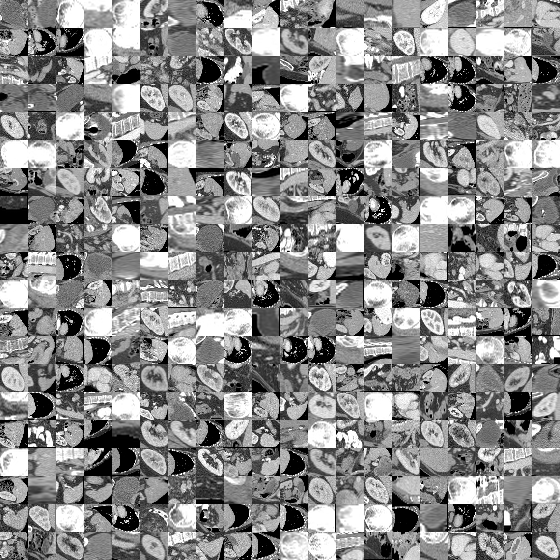

In [16]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)